In [1]:
import sympy as sym
sym.init_printing()

In [2]:
import random
import numpy as np

In [3]:
from sympy import oo

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
r, t, k, i = sym.symbols('r, t, k, i')

Math checks for me
------------------

In [6]:
rhs = (r - 1) ** 2
lhs = (1 - r) ** 2

In [7]:
rhs.expand() == lhs.expand()

True

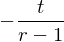

In [8]:
((1 - r) * t / (r - 1) ** 2).simplify()

In [9]:
((r * t - 1) ** 2).expand()

First formulation (without t)
-------------------


In [10]:
selective = 1 / (1 - r)

In [11]:
indiscriminate = ((1 - r) * sym.summation(i * r ** (i - 1), (i, 1, k)))

In [12]:
last_turn = (k + 1) * r ** k

In [13]:
indiscriminate += last_turn

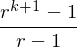

In [14]:
indiscriminate.simplify()

It can be seen that indiscriminate cost is always less with this formulation.

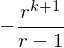

In [15]:
(selective - indiscriminate.simplify()).simplify() 

Because $\frac{r^{k + 1}}{1 - r}$ is always positive and non negative.

Selective (with t)
---------

For selective the model is simple. At each time step there is a $(1 - r)$ probability to get a rhino. If a selective gets a rhino then they need $t$ time to take the horn.

Thus $T_s = (1 - r) t + r (1 - r) (1 + t) + r ^ 2 (1- r)(2 + t) \dots$

which can be written as:

$$(1 - r) \sum_{i=0} ^ {\infty} r ^ i (i + t)$$

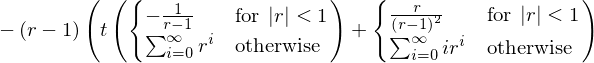

In [43]:
selective_risk = (1 - r) * sym.summation(r ** (i) * (i + t), (i, 0, oo))
selective_risk.simplify()

## Because $|r| < 1$:

$$T_s = \frac{r + t(1 - r)}{(1 - r)}$$

In [44]:
exprs = (-r / (r - 1) + t).simplify()

In [45]:
def selective_risk(r_val, t_val):
    return (r_val + t_val * (1 - r_val)) / (1 - r_val)

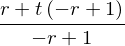

In [46]:
selective_risk(r, t)

In [47]:
(selective_risk(r, t) - exprs).factor()

**Behaviour of risk depending on $r$**

In [48]:
rs = np.linspace(0, 0.99, 100)
t_val = 1
ys = [selective_risk(r_val, t_val) for r_val in rs]

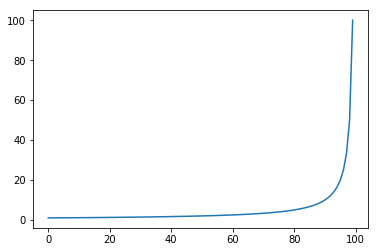

In [49]:
plt.plot(ys);

**Behaviour of risk for $t= 1$**

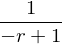

In [50]:
selective_risk(r, 1)

**Simulation of selective risk**

In [73]:
def selective_risk_simulation(r_val, t_val, seed):
    sequence = [(1 - r_val) * t_val]
    s_i = 0
    np.random.seed(seed)
    while np.random.choice([True, False], p=[(1 - r_val), r_val]) == False:
        s_i += 1
        sequence.append((1 - r_val) * r_val ** s_i * (s_i + t_val))
    return sum(sequence)

In [78]:
timesteps = range(10000)
ys = []
for timestep in timesteps:
    ys.append(selective_risk_simulation(0.60, 0.5, seed=timestep))

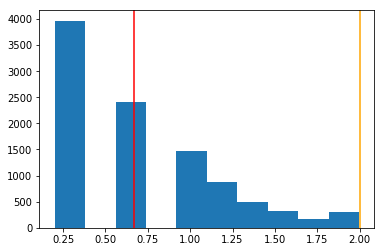

In [79]:
plt.hist(ys);
plt.axvline(np.mean(ys), color='red');
plt.axvline(selective_risk(0.6, 0.5), color='orange');

Indiscriminate (with t)
-----------------------

$T_d = t (1 - r) + 2rt (1 - r) + 3r^{2}t(1 - r)+ \dots + (\frac{1}{\theta_r} - 1)r ^ {\frac{1}{\theta_r} - 2} + \frac{1}{\theta_r} r ^ {\frac{1}{\theta_r} - 1}$

which can be writen as:
    
$$T_d = t (1 - r) \sum_{i=1}^{N_r - 1} i r ^{i - 1} + N_r t r ^ {(N_r - 1)}$$ 

where $$N_r = \frac{1}{\theta_r}$$

In [91]:
N_r = sym.symbols('N_r')

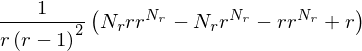

In [92]:
sym.summation(i * r ** (i - 1), (i, 1, N_r - 1))

In [93]:
force_exist = N_r * r ** (N_r - 1) * t
force_exist

In [94]:
indiscriminate = (t * (1 - r) * sym.summation(i * r ** (i), (i, 0, N_r - 2)))

In [95]:
indiscriminate += force_exist 

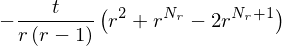

In [96]:
indiscriminate.simplify()

In [113]:
def indiscriminate_risk(r_val, t_val, theta_r_val):
    N_r_val = 1 / theta_r_val
    return t_val * (r_val ** 2 + r_val ** N_r_val - 2 * r_val ** (N_r_val + 1))

**Behaviour of risk depending on $r$**

In [114]:
rs = np.linspace(0, 0.99, 100)
t_val = 1
ys = [indiscriminate_risk(r_val, t_val, 0.3) for r_val in rs]

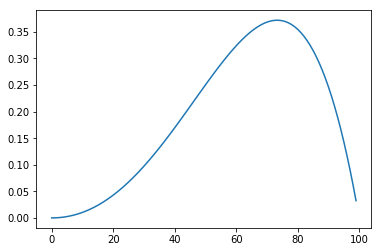

In [115]:
plt.plot(ys);

**Behaviour of risk for $t= 1$**

In [116]:
theta_r = sym.symbols(r'\theta_r')

In [117]:
indiscriminate_risk(r_val=r, t_val=1, theta_r_val=theta_r).factor()

**Simulate**

In [124]:
def indiscriminate_risk_simulation(r_val, t_val, theta_r_val, seed):
    sequence = [(1 - r_val) * t_val * r_val]
    s_i = 0
    np.random.seed(seed)
    while np.random.choice([True, False], p=[(1 - r_val), r_val]) == False:
        if s_i * theta_r_val >= 1:
            return sum(sequence) + (1 / theta_r_val) * r_val ** ((1 / theta_r_val) - 1)
        s_i += 1
        sequence.append((1 - r_val) * r_val ** (s_i - 1) * t_val)
    return sum(sequence)

In [125]:
timesteps = range(300)
ys = []
for timestep in timesteps:
    ys.append(indiscriminate_risk_simulation(0.6, 0.5, 0.1, timestep))

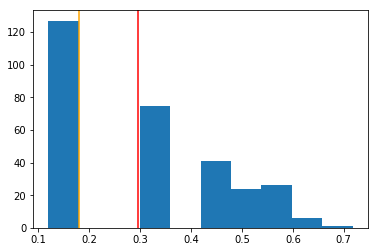

In [129]:
plt.hist(ys);
plt.axvline(np.mean(ys), color='red');
plt.axvline(indiscriminate_risk(0.6, 0.5, 0.1), color='orange');